In [3]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

import pandas as pd

from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import CelebA
from IPython.display import Image
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import os
import PIL
%matplotlib inline
plt.style.use("ggplot")

C:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Проверим работоспособность детектора лиц

In [2]:
from deepface import DeepFace
face_objs = DeepFace.extract_faces(img_path = "./img_align_celeba/202584.jpg", 
        target_size = (128, 128), 
)

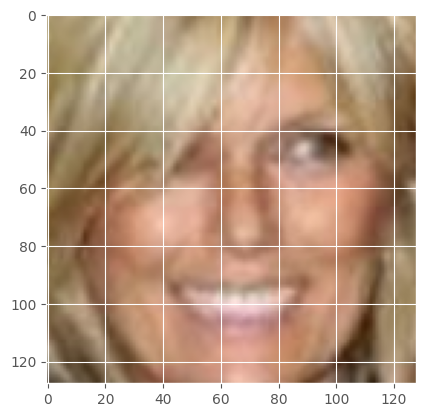

In [3]:
plt.imshow(face_objs[0]['face'])

Детекртирование лиц, обрезка и центрирование

In [5]:
l = os.listdir(path="./img_align_celeba/")
for i in range(60000, 90000):
    try:
        face_objs = DeepFace.extract_faces(img_path =os.path.join("./img_align_celeba/", l[i]), target_size = (128, 128))
        if (face_objs[0]['confidence']>5.0):
            save_image(torch.Tensor(face_objs[0]['face'].transpose(2,0,1).copy()), os.path.join("./custom_celeba/", l[i]))
    except ValueError:
        None
    

In [25]:
path = "./custom_celeba/"
device = "cuda" if torch.cuda.is_available() else "cpu"
sample_dir = "./images/"
batch_size = 64
image_size = 64
noise_dim = 100
channels = 3
critic_iterations = 5
num_epochs=50
lr = 1e-5
gp = 10

Создадим кастомный датасет с обрезанными лицами

In [28]:
path = "./custom_celeba/"
device = "cuda" if torch.cuda.is_available() else "cpu"
sample_dir = "./images3/"
attr_list = "list_attr_celeba.csv"
batch_size = 64
image_size = 64
noise_dim = 100
channels = 3
num_classes = 2
critic_iterations = 4
num_epochs=100
lr = 1e-4
gp = 10

In [17]:
class Dataset(Dataset):
    def __init__(self, root_dir = path, data_length = 25000, transform=None):
        self.l = os.listdir(path=path)
        self.root_dir = root_dir
        self.len = data_length
        self.transform = transform
        self.attr = pd.read_csv(attr_list, index_col=[0])
        self.attr = self.attr["Male"].replace(-1,0)
        
    def __getitem__(self, idx):
        name = self.l[idx+1]
        image = PIL.Image.open(os.path.join(self.root_dir, name))
        label = self.attr[name]
        if self.transform is not None:
            image = self.transform(image)
        sample = {'image': image, 'label': label}
        return sample
    
    def __len__(self):
        return self.len

In [18]:
transform=transforms.Compose(
[
transforms.Resize((image_size ,image_size)),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = Dataset(transform = transform)

In [19]:
data_loader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [20]:
class Generator(nn.Module):
    def __init__(self, noise_dim, channels, features_g, num_class, image_size):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(num_class, num_class)
        self.image_size = image_size
        self.num_class = num_class
        self.main = nn.Sequential(
            self._block(noise_dim+num_class, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x, label):
        emb = self.embed(label).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, emb], dim=1)
        return self.main(x)
    
class Critic(nn.Module):
    def __init__(self, channels, features_d, num_classes, image_size):
        super(Critic, self).__init__()
        self.embed = nn.Embedding(num_classes, image_size*image_size)
        self.image_size = image_size
        self.num_classes = num_classes
        self.main = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels+1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x, labels):
        emb = self.embed(labels).view(labels.shape[0], 1, self.image_size, self.image_size)
        x = torch.cat([x, emb], dim=1)
        return self.main(x)

In [21]:
def gradient_penalty(critic, labels, real, fake, device=device):
    batch_size, ch, h, w = real.shape
    #intrepolate images
    epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1, ch, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    #critic loss
    mixed_scores = critic(interpolated_images, labels)
    #computing gradient of mixed scores
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [22]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [23]:
CG = Generator(noise_dim, channels, 32, num_classes, image_size).to(device)
CC = Critic(channels, 64, num_classes, image_size).to(device)
initialize_weights(CG)
initialize_weights(CC)

In [24]:
optim_CG = torch.optim.Adam(CG.parameters(), lr=lr, betas=(0.0, 0.9))
optim_CC = torch.optim.Adam(CC.parameters(), lr=lr, betas=(0.0, 0.9))

In [25]:
def denorm(img):
    AA = img.clone()
    AA = AA.view(AA.size(0),AA.size(1), -1)
    AA -= AA.min(2, keepdim=True)[0]
    AA /= AA.max(2, keepdim=True)[0]
    AA = AA.view(AA.size(0), 3, 64, 64)
    return AA

In [26]:
def save_images(index):
    z = torch.randn(batch_size, noise_dim, 1, 1).to(device)
    gens_label = torch.randint(0, 1, (batch_size,)).to(device)
    fake_images = CG(z, gens_label)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)

In [27]:
c_losses, g_losses, w_losses = [], [], []

In [32]:
num_epochs = 50

Epoch [1/50] Batch 89/390                   Loss D: -8.4439, loss G: 79.0796
Epoch [1/50] Batch 179/390                   Loss D: -6.2860, loss G: 91.2136
Epoch [1/50] Batch 269/390                   Loss D: -5.6506, loss G: 94.8577
Epoch [1/50] Batch 359/390                   Loss D: -5.4801, loss G: 81.5106
Saving fake_images-0001.png
Epoch [2/50] Batch 89/390                   Loss D: -5.8268, loss G: 86.9491
Epoch [2/50] Batch 179/390                   Loss D: -4.2313, loss G: 82.7736
Epoch [2/50] Batch 269/390                   Loss D: -8.5976, loss G: 81.5205
Epoch [2/50] Batch 359/390                   Loss D: -6.8279, loss G: 82.1007
Saving fake_images-0002.png
Epoch [3/50] Batch 89/390                   Loss D: -7.6819, loss G: 87.2746
Epoch [3/50] Batch 179/390                   Loss D: -6.5709, loss G: 77.6701
Epoch [3/50] Batch 269/390                   Loss D: -6.3824, loss G: 86.9349
Epoch [3/50] Batch 359/390                   Loss D: -5.6651, loss G: 79.5345
Saving fake

Epoch [25/50] Batch 89/390                   Loss D: -5.0480, loss G: 67.6201
Epoch [25/50] Batch 179/390                   Loss D: -6.7786, loss G: 55.6472
Epoch [25/50] Batch 269/390                   Loss D: -8.0131, loss G: 64.8941
Epoch [25/50] Batch 359/390                   Loss D: -6.1198, loss G: 70.2426
Saving fake_images-0025.png
Epoch [26/50] Batch 89/390                   Loss D: -5.2578, loss G: 73.3164
Epoch [26/50] Batch 179/390                   Loss D: -7.5808, loss G: 64.1430
Epoch [26/50] Batch 269/390                   Loss D: -9.1159, loss G: 68.0030
Epoch [26/50] Batch 359/390                   Loss D: -4.8039, loss G: 63.5310
Saving fake_images-0026.png
Epoch [27/50] Batch 89/390                   Loss D: -6.2435, loss G: 75.9590
Epoch [27/50] Batch 179/390                   Loss D: -5.6638, loss G: 50.0633
Epoch [27/50] Batch 269/390                   Loss D: -6.7935, loss G: 60.5808
Epoch [27/50] Batch 359/390                   Loss D: -7.7560, loss G: 53.2721

Saving fake_images-0048.png
Epoch [49/50] Batch 89/390                   Loss D: -6.6326, loss G: 52.2563
Epoch [49/50] Batch 179/390                   Loss D: -7.6433, loss G: 53.1751
Epoch [49/50] Batch 269/390                   Loss D: -5.7915, loss G: 59.0412
Epoch [49/50] Batch 359/390                   Loss D: -5.8176, loss G: 47.7965
Saving fake_images-0049.png
Epoch [50/50] Batch 89/390                   Loss D: -6.5689, loss G: 43.1580
Epoch [50/50] Batch 179/390                   Loss D: -5.6456, loss G: 54.0246
Epoch [50/50] Batch 269/390                   Loss D: -10.4471, loss G: 51.3084
Epoch [50/50] Batch 359/390                   Loss D: -5.4504, loss G: 48.2682
Saving fake_images-0050.png


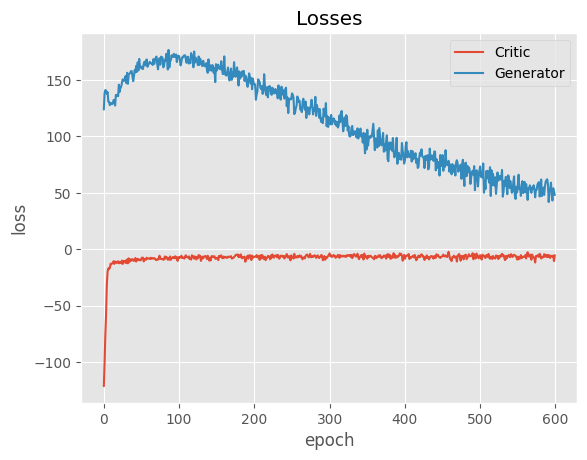

In [33]:
CG.train()
CC.train()
len_ = len(data_loader)
for epoch in range(num_epochs):
    for idx, batch in enumerate(data_loader):
        real = batch['image'].to(device)
        labels = batch['label'].to(device)
        b_size = real.shape[0]
        
        for _ in range(critic_iterations):
            z = torch.randn(batch_size, noise_dim, 1, 1).to(device)
            fake = CG(z, labels)
            real_output = CC(real, labels).view(-1)
            fake_output = CC(fake, labels).view(-1)
            penalty = gradient_penalty(CC, labels, real, fake, device)
            loss_critic = (
                -(torch.mean(real_output) - torch.mean(fake_output)) + gp * penalty
            )
            CC.zero_grad()
            loss_critic.backward(retain_graph=True)
            optim_CC.step()
            
        output = CC(fake, labels).view(-1)
        loss_gen = -torch.mean(output)
        CG.zero_grad()
        loss_gen.backward()
        optim_CG.step()
        if (idx+1) % 90 == 0:
            c_losses.append(loss_critic.item())
            g_losses.append(loss_gen.item())
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {idx}/{len_} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )
    with torch.no_grad():
        save_images(epoch+1)
        
plt.plot(c_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Critic", "Generator"])
plt.title("Losses");

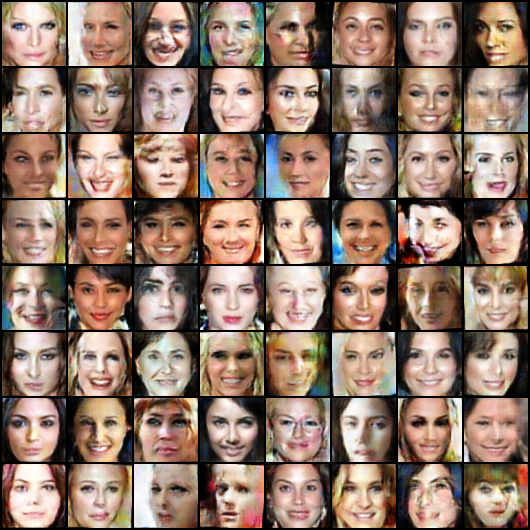

In [11]:
PIL.Image.open("images3/fake_images-0100.png")